In [1]:
# Magic functions -- Run Once
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Move up one folder to reach the repo root
%cd ..

from utils.notebook.generic import full_width_notebook
full_width_notebook()

/fast-ssd/dev/maitrise/film-aqa


In [2]:
from IPython.core.display import Markdown
from main import parse_args_string, prepare_for_task

data_root_path = "data"
config_path = "config/film_reduced.json"
random_seed = 667
image_size = 224
show_test_set_stats = False

data_version_name = "v3_fixed_5k_40_inst_1024_win_50_overlap"

# FIXME : Clear mean & std might be wrong (It is written in the config file)

arguments = (
    f"--notebook_data_analysis --version_name {data_version_name} --config_path {config_path} --batch_size 4 "
    f"--random_seed {random_seed} --dict_folder questions --resize_to_square_images --pad_to_largest_image "
    f"--raw_img_resize_val {image_size} --raw_img_resize_based_on_width --no_feature_extractor --normalize_with_clear_stats"
)
            
args = parse_args_string(arguments)
task_and_more, dataloaders, model_and_more = prepare_for_task(args)
print("Preparation done")
task, args, flags, paths, device = task_and_more
film_model_config, film_model, optimizer, loss_criterion, scheduler, tensorboard = model_and_more
datasets = {set_type:dloader.dataset for set_type, dloader in dataloaders.items() if set_type != 'test' or show_test_set_stats}


/fast-ssd/dev/maitrise/film-aqa/models/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Task 'Notebook Data Analysis' for version 'v3_fixed_5k_40_inst_1024_win_50_overlap'

Using device 'cuda:0'
Creating Datasets
Creating Dataloaders
Preparation done


## Questions Analysis

In [3]:
from collections import Counter, defaultdict

def get_question_metrics(dataset):
    # Global stats
    global_metrics = {
        'vocab_dist': Counter(),
        'answer_dist': Counter(),
        'answer_family_dist': Counter(),
        'total_unk_count': 0,
        'total_word_count': 0,
        'unique_word_list': dict(),
        'unique_word_count': 0
    }
    
    
    per_game_metrics = []
    
    for i in range(len(dataset)):
        game = dataset.get_game(i, decode_tokens=True)
        words = game['question'].split(' ')
        
        # Answer related
        answer = game['answer']
        global_metrics['answer_dist'][answer] += 1
        answer_family = dataset.answer_to_family[answer]
        global_metrics['answer_family_dist'][answer_family] += 1
        
        
        # Program Related
        question_program = game['program']
        relation_nodes = [node for node in question_program if node['type'] == 'relate']
        nb_relation = len(relation_nodes)
        
        # Repeating words in question
        # Frequency of word per question
        # vocabulary distribution
        # Answer distribution
        # Answer family
        # Refering to another object with similar properties (Ex another loud sound, another sound of the same instrument, etc)
        game_metrics = {
            'id': game['id'],
            'answer': answer,
            'answer_family': answer_family,
            'have_relation': nb_relation > 0,
            'nb_relation': nb_relation,
            'relations': [node['value_inputs'][0] for node in relation_nodes],
            'nb_output_per_relation': [len(node['_output']) for node in relation_nodes],
            'unk_count': 0,
            'length': len(words),
            'refer_to_answer_family_in_question': answer_family in words,   # FIXME : This won't work for count, position_global and postion_instrument
            'answer_in_question': answer in words,    # FIXME : We are most probably refering to another object of the scene IE : What is the loudness of the cello playing after the "loud" violin ?
        }
        
        for word in words:
            if word != '<unk>':
                global_metrics['vocab_dist'][word] += 1
                global_metrics['total_word_count'] += 1
                global_metrics['unique_word_list'][word] = 1   # We only need the key, faster to assign 1 everytime then check if present in list
                
            else:
                game_metrics['unk_count'] += 1
                global_metrics['total_unk_count'] += 1
                
                
        per_game_metrics.append(game_metrics)
            
            
    global_metrics['unique_word_list'] = list(global_metrics['unique_word_list'].keys())
    global_metrics['unique_word_count'] = len(global_metrics['unique_word_list'])
                
    return global_metrics, per_game_metrics
        
    
def parse_program(question_program):
    relations = []
    
    for i, node in enumerate(question_program):
        if node['type'] == 'scene':
            # Nothing to do with scene node
            continue
            
        elif node['type'].startswith('filter'):
            print("filter")
        elif node['type'] == 'relate':
            relations.append(node['value_input'][0])
            # TODO : How many attribute define the "related" value
        elif node['type'].startswith('query'):
            print("YO")
        
        
        

question_global_metrics, per_game_metrics = get_question_metrics(datasets['train'])

In [4]:
datasets['train'].get_game(0, decode_tokens=True)

{'id': 0,
 'image': {'id': 0, 'filename': 'CLEAR_train_000000.png', 'set': 'train'},
 'question': 'what is the loudness of the bright trumpet sound playing before the quiet bright sound <unk>',
 'answer': 'loud',
 'program': [{'_output': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   'inputs': [],
   'type': 'scene',
   'value_inputs': []},
  {'_output': [1, 2, 5, 6, 8],
   'inputs': [0],
   'type': 'filter_brightness',
   'value_inputs': ['bright']},
  {'_output': [5],
   'inputs': [1],
   'type': 'filter_loudness',
   'value_inputs': ['quiet']},
  {'_output': 5, 'inputs': [2], 'type': 'unique', 'value_inputs': []},
  {'_output': [0, 1, 2, 3, 4],
   'inputs': [3],
   'type': 'relate',
   'value_inputs': ['before']},
  {'_output': [1, 2],
   'inputs': [4],
   'type': 'filter_brightness',
   'value_inputs': ['bright']},
  {'_output': [1],
   'inputs': [5],
   'type': 'filter_instrument',
   'value_inputs': ['trumpet']},
  {'_output': 1, 'inputs': [6], 'type': 'unique', 'value_inputs': []},
  {'_out

## Scenes Analysis

In [5]:
from utils.notebook.dataset_analysis import scene_object_per_position, plot_attribute_per_position_matrix, plot_scene_distribution_per_attribute

## [Train] Scene Position Analysis

<IPython.core.display.Javascript object>


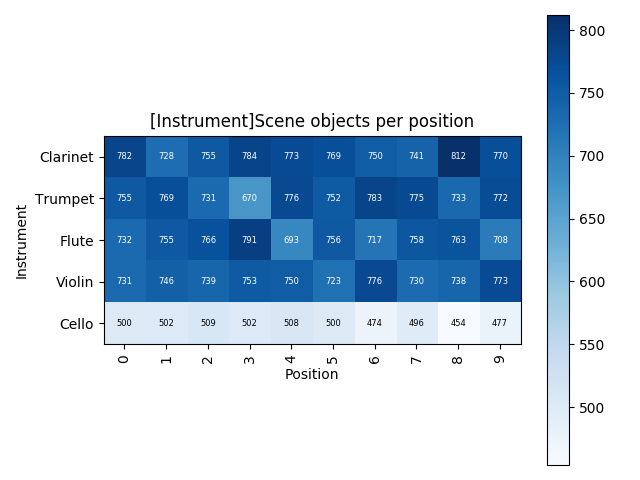

<IPython.core.display.Javascript object>


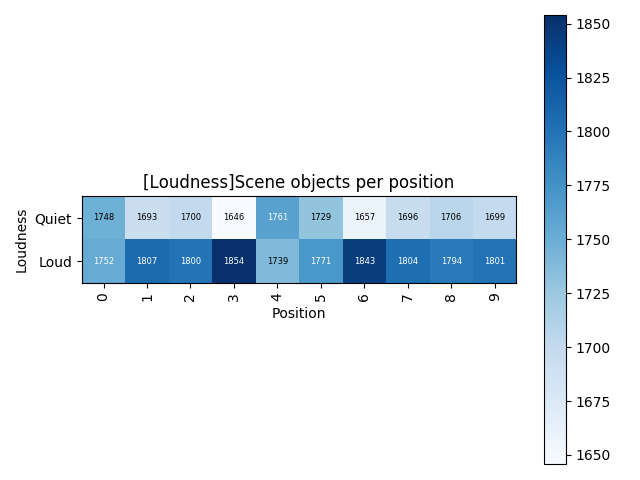

<IPython.core.display.Javascript object>


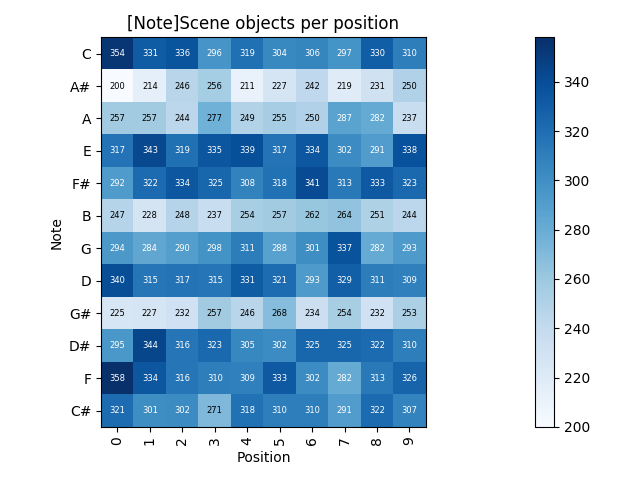

<IPython.core.display.Javascript object>


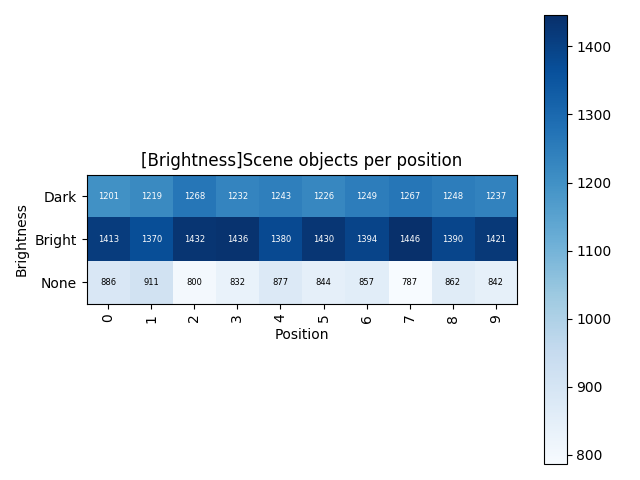

<IPython.core.display.Javascript object>


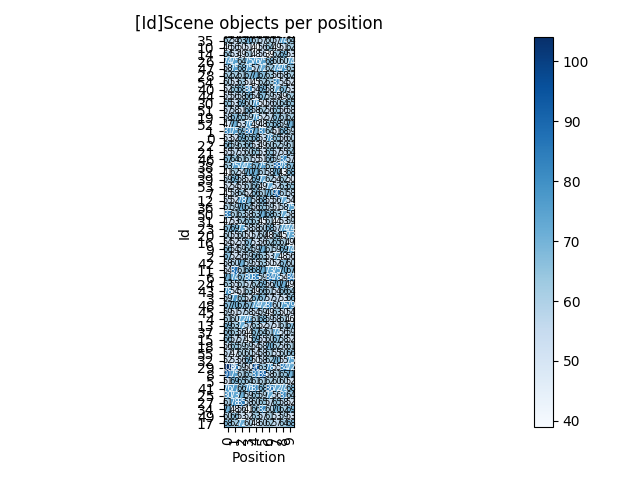

## [Val] Scene Position Analysis

<IPython.core.display.Javascript object>


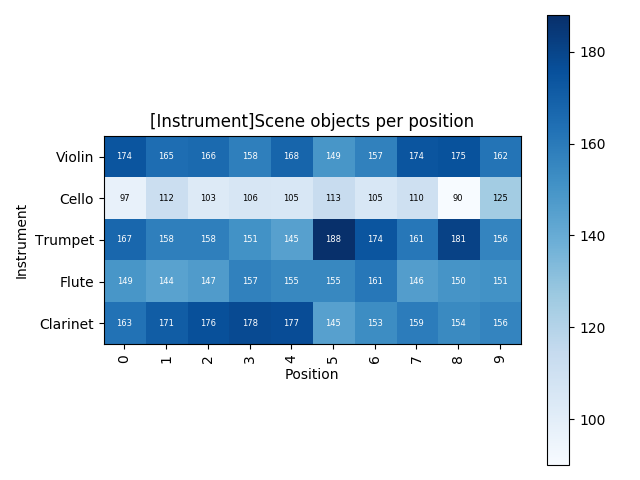

<IPython.core.display.Javascript object>


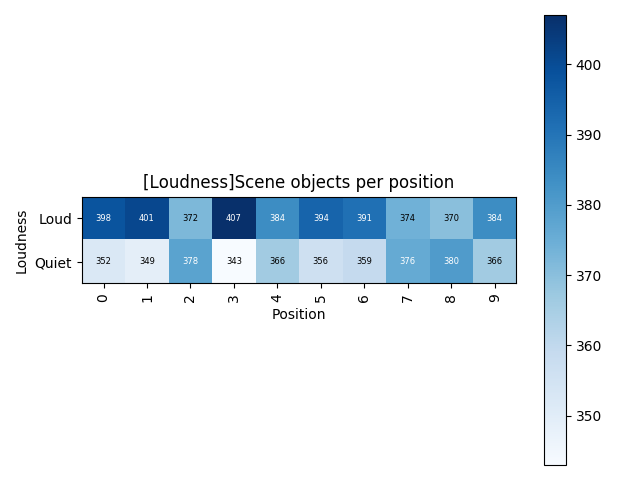

<IPython.core.display.Javascript object>


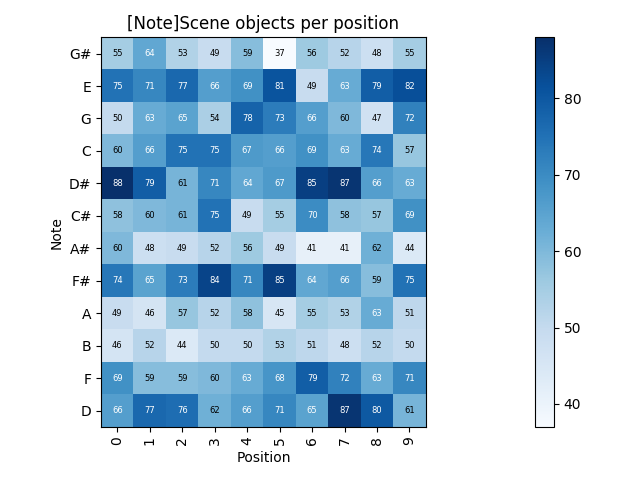

<IPython.core.display.Javascript object>


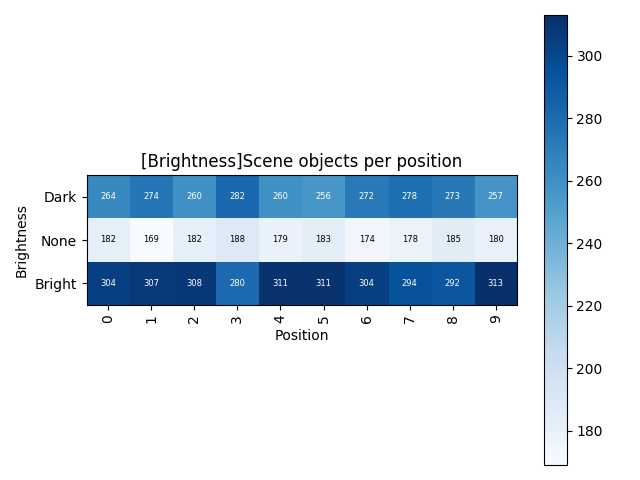

<IPython.core.display.Javascript object>


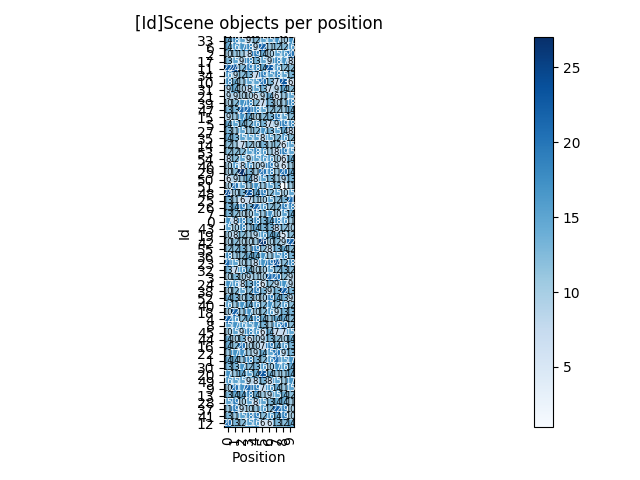

In [6]:
# Scene Position Analysis per attribute
attributes = ['instrument', 'loudness', 'note', 'brightness', 'id']

for set_type, dataset in datasets.items():
    display(Markdown(f"## [{set_type.capitalize()}] Scene Position Analysis"))
    for attribute in attributes:
        obj_per_position = scene_object_per_position(list(dataset.scenes.values()), attribute=attribute)
        plot_attribute_per_position_matrix(obj_per_position, attribute)

## [Train] Scene distribution Analysis

<IPython.core.display.Javascript object>


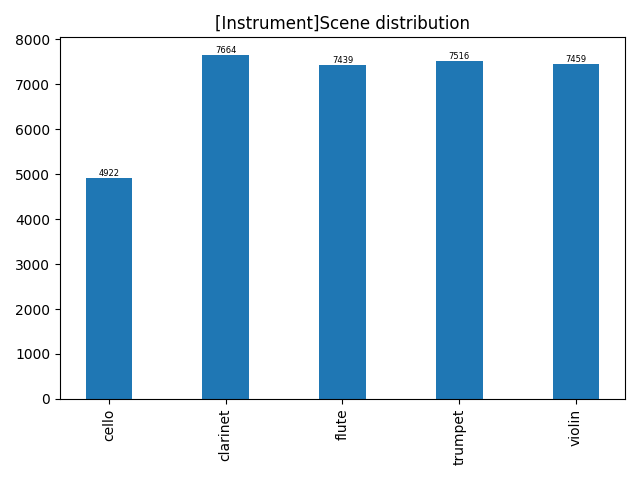

<IPython.core.display.Javascript object>


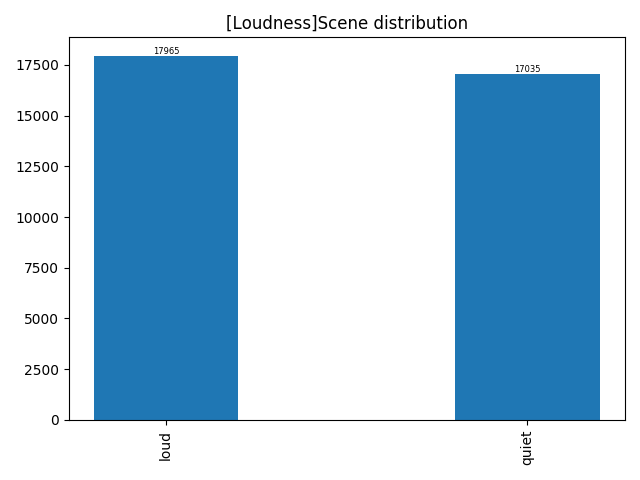

<IPython.core.display.Javascript object>


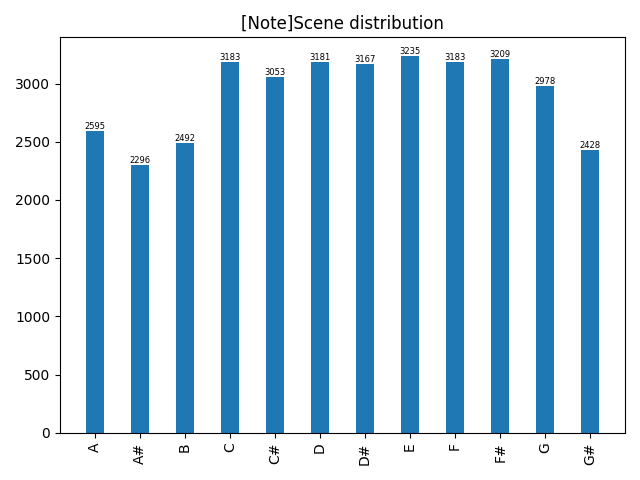

<IPython.core.display.Javascript object>


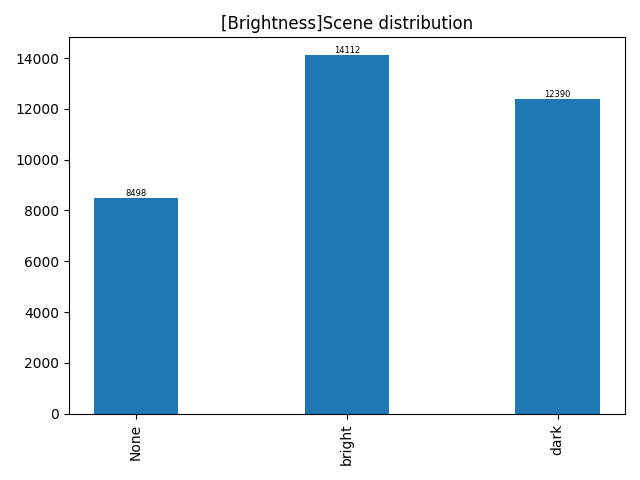

<IPython.core.display.Javascript object>


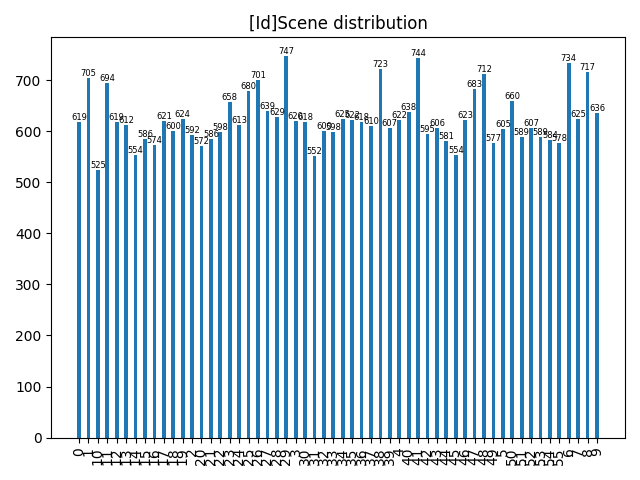

## [Val] Scene distribution Analysis

<IPython.core.display.Javascript object>


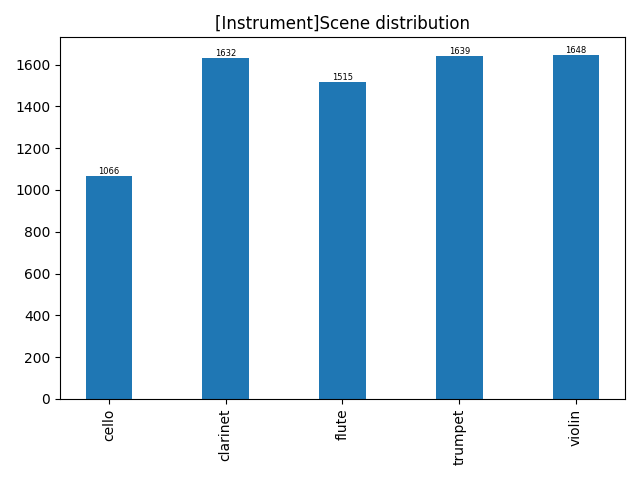

<IPython.core.display.Javascript object>


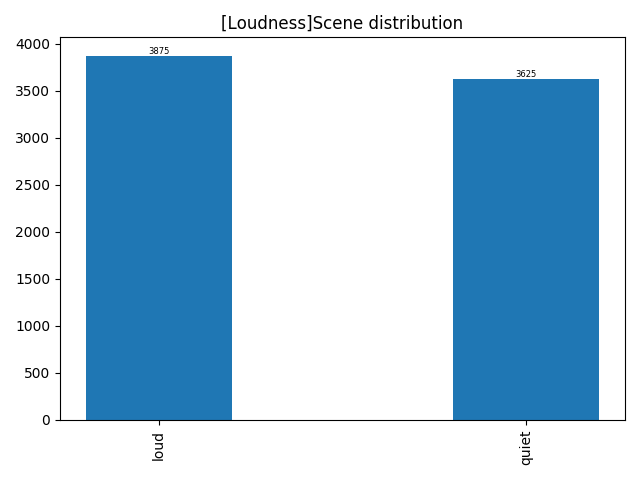

<IPython.core.display.Javascript object>


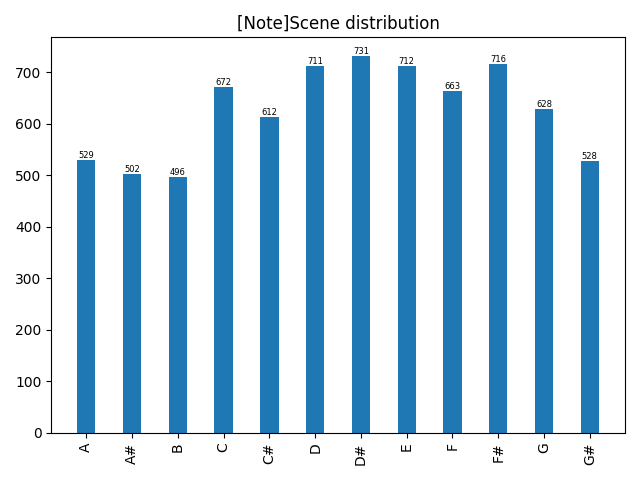

<IPython.core.display.Javascript object>


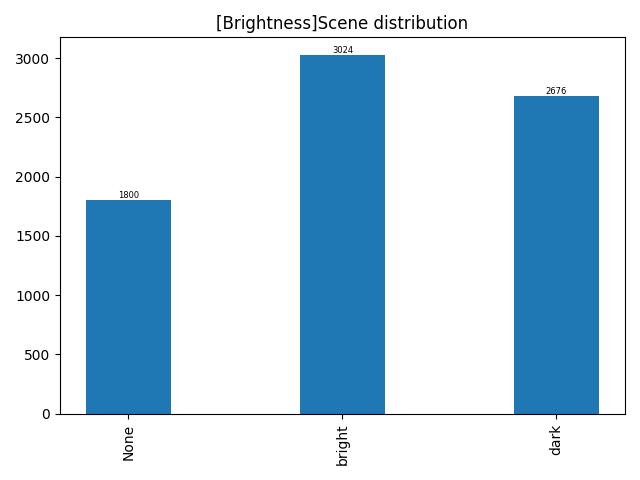

<IPython.core.display.Javascript object>


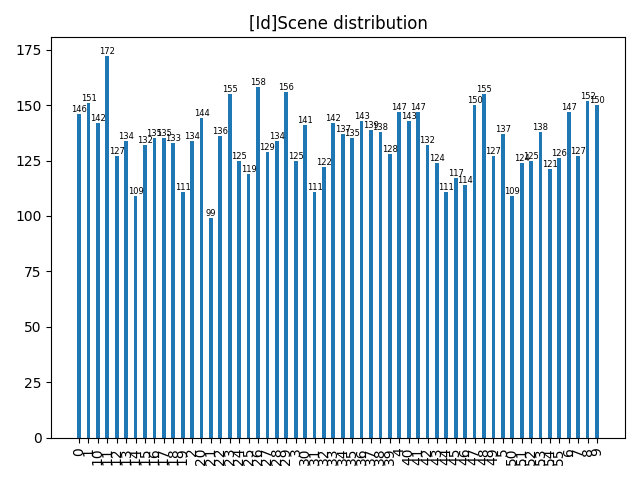

In [7]:
# Scene distribution per attribute

for set_type, dataset in datasets.items():
    display(Markdown(f"## [{set_type.capitalize()}] Scene distribution Analysis"))
    for attribute in attributes:
        plot_scene_distribution_per_attribute(list(dataset.scenes.values()), attribute, norm_hist=False)

## [Train] Scene durations Analysis

/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<IPython.core.display.Javascript object>


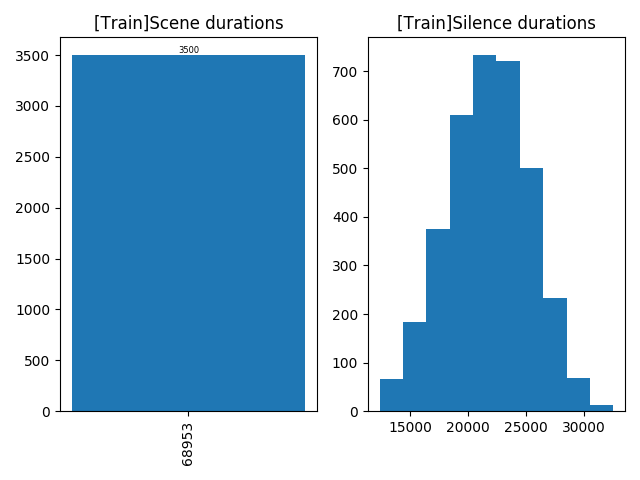

/fast-ssd/dev/maitrise/film-aqa/utils/notebook/plot.py:85: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<IPython.core.display.Javascript object>


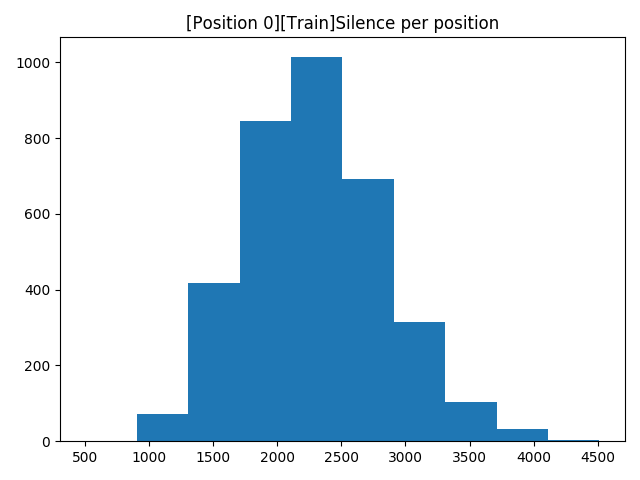

<IPython.core.display.Javascript object>


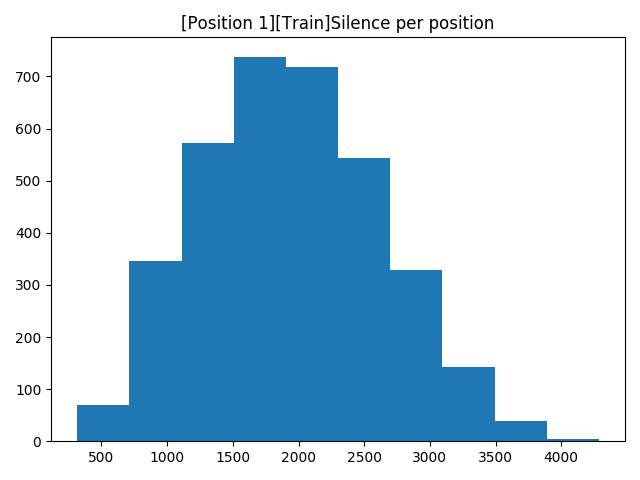

<IPython.core.display.Javascript object>


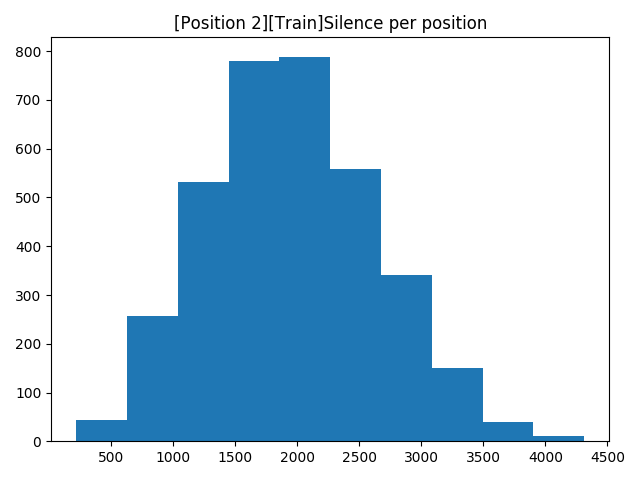

<IPython.core.display.Javascript object>


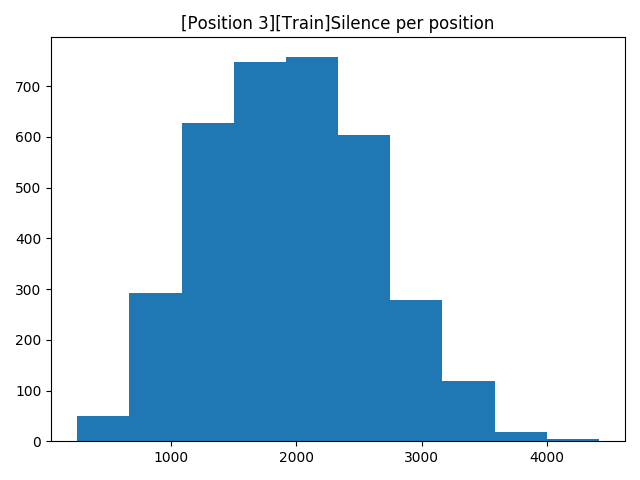

<IPython.core.display.Javascript object>


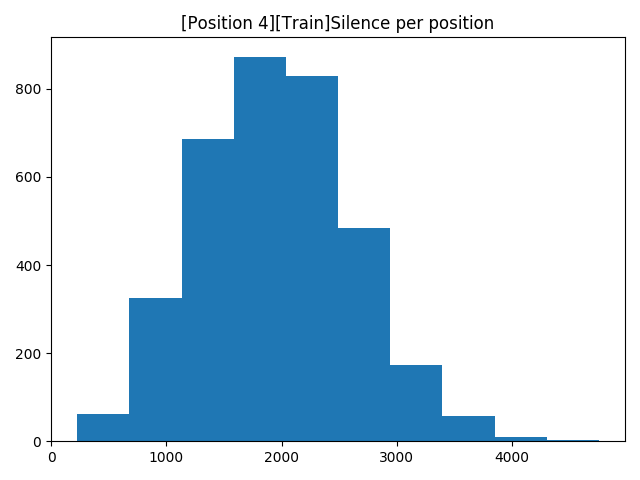

<IPython.core.display.Javascript object>


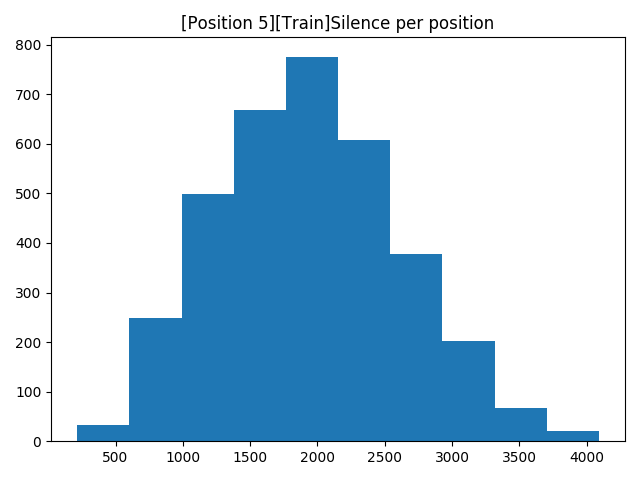

<IPython.core.display.Javascript object>


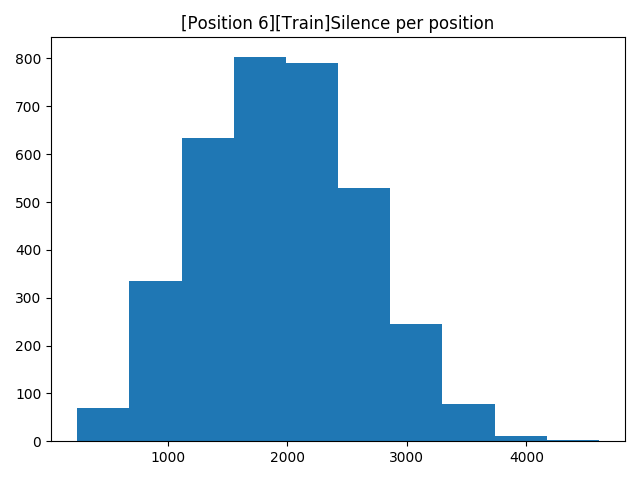

<IPython.core.display.Javascript object>


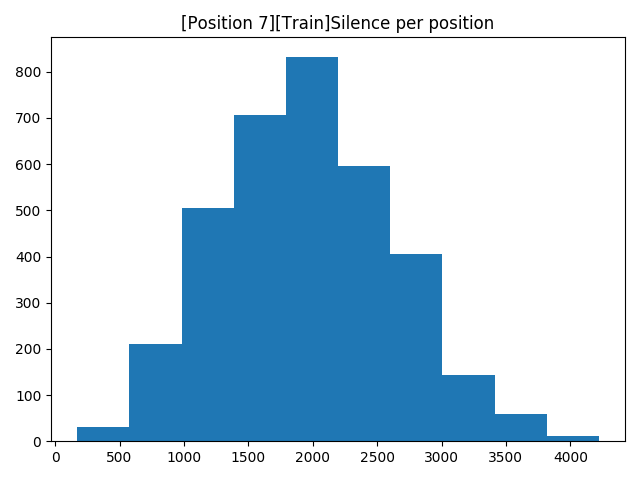

<IPython.core.display.Javascript object>


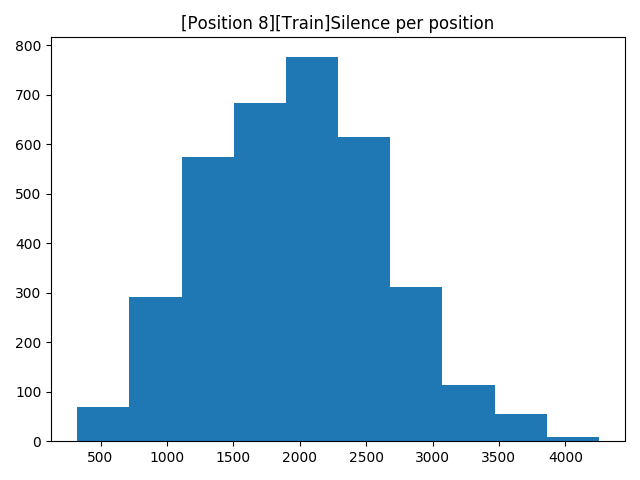

<IPython.core.display.Javascript object>


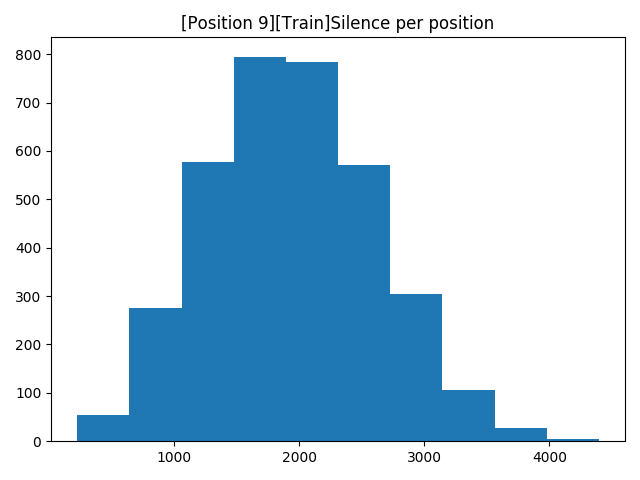

<IPython.core.display.Javascript object>


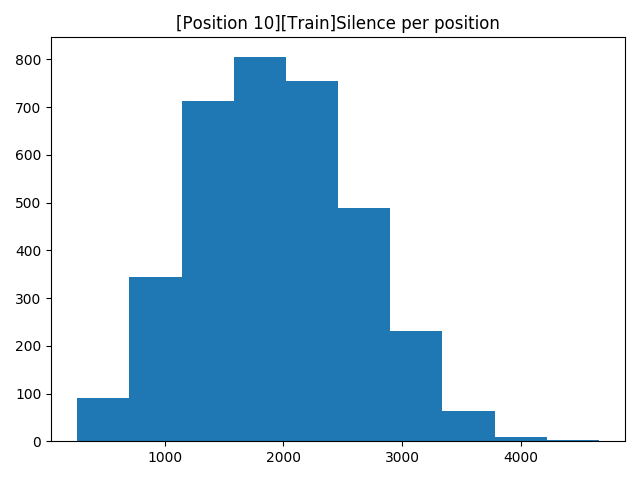

## [Val] Scene durations Analysis

<IPython.core.display.Javascript object>


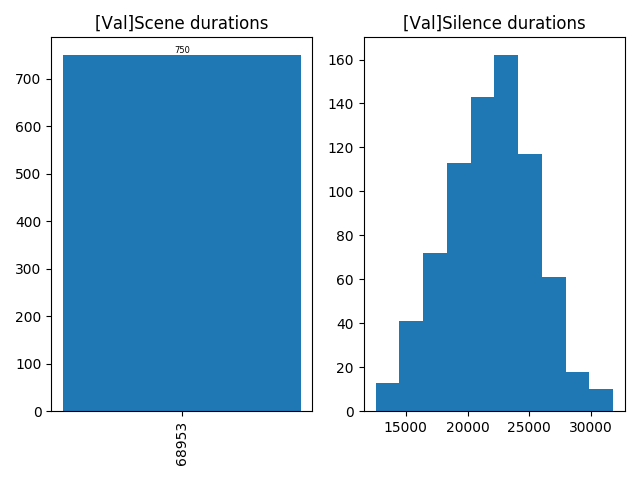

<IPython.core.display.Javascript object>


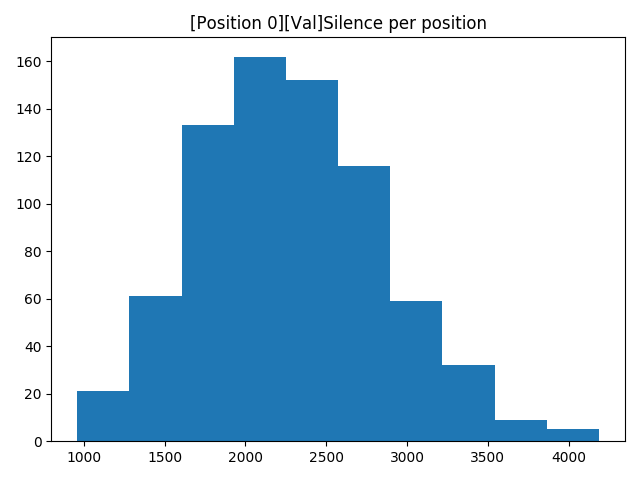

<IPython.core.display.Javascript object>


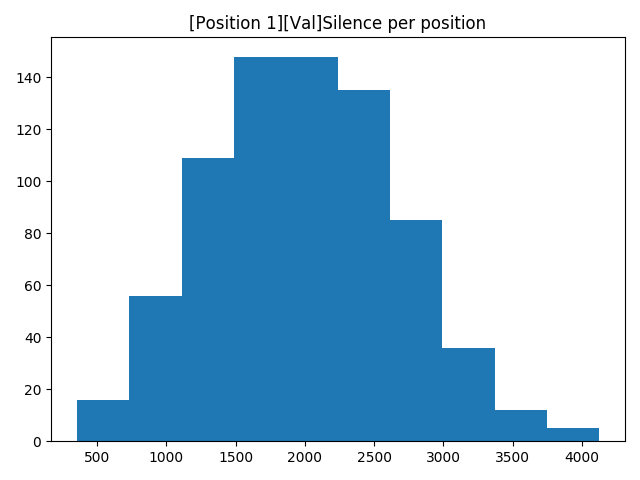

<IPython.core.display.Javascript object>


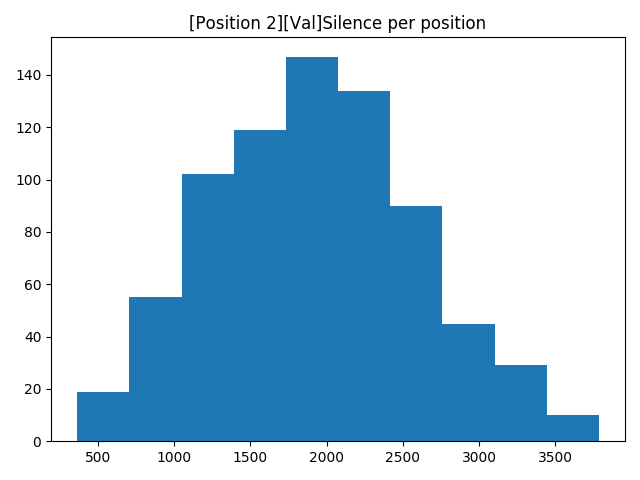

<IPython.core.display.Javascript object>


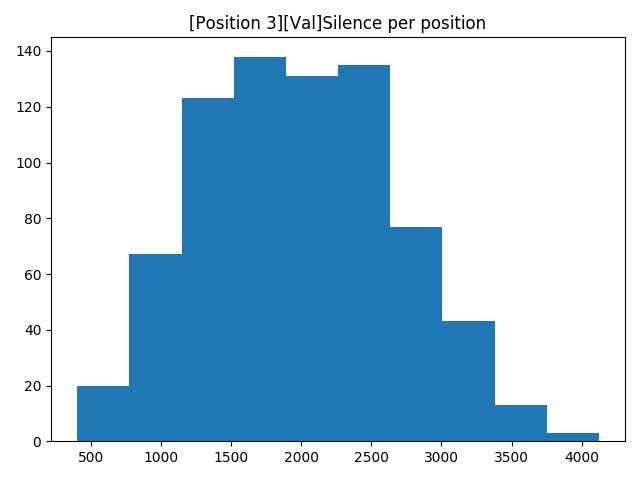

<IPython.core.display.Javascript object>


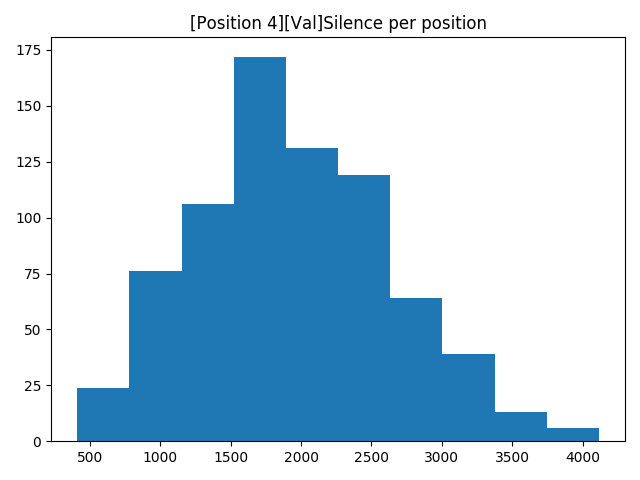

<IPython.core.display.Javascript object>


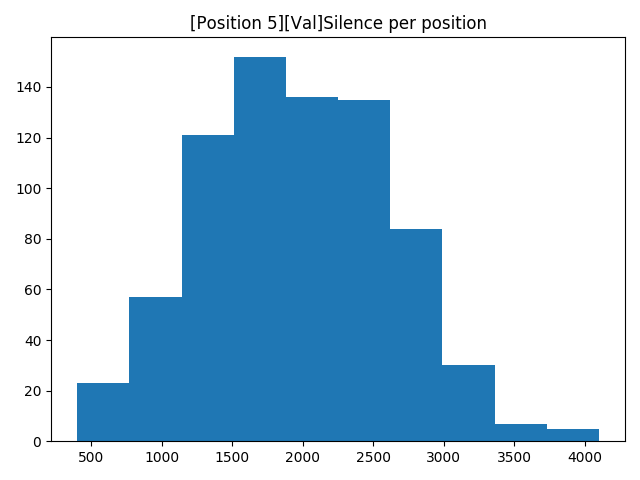

<IPython.core.display.Javascript object>


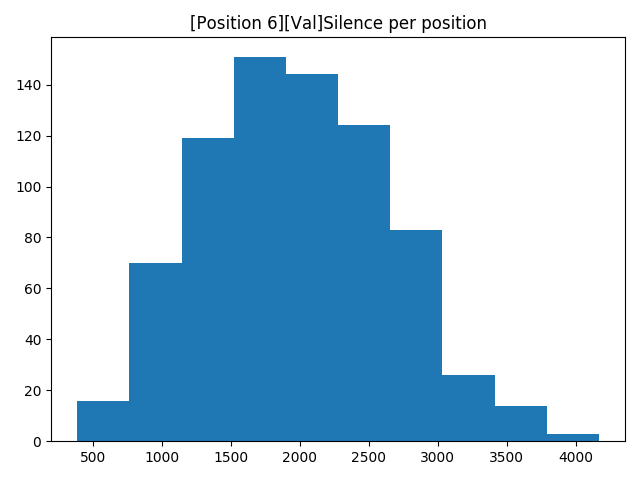

<IPython.core.display.Javascript object>


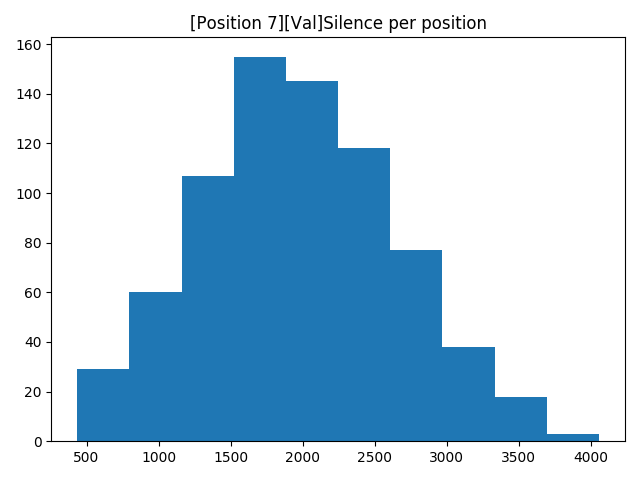

<IPython.core.display.Javascript object>


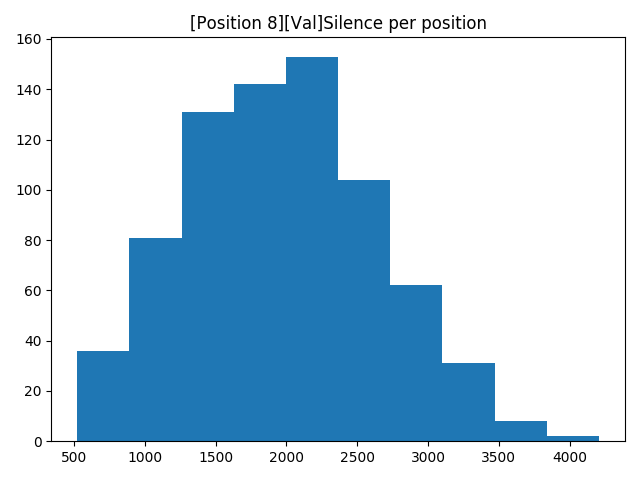

<IPython.core.display.Javascript object>


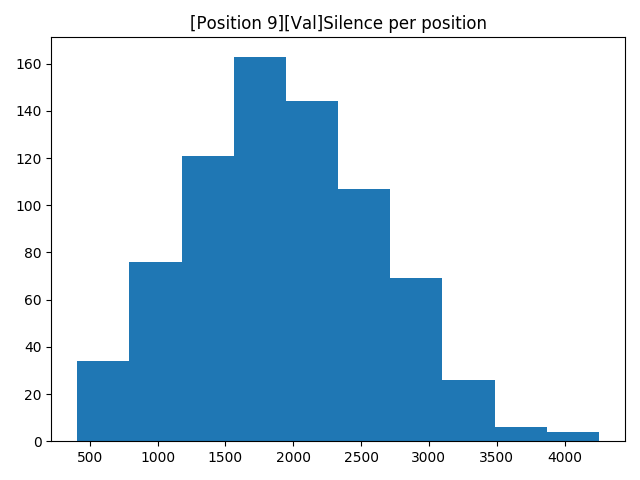

<IPython.core.display.Javascript object>


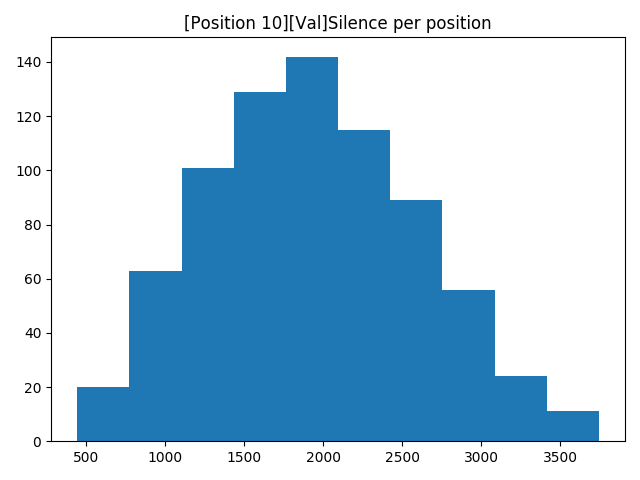

In [8]:
# Durations
from utils.notebook.dataset_analysis import plot_scene_duration_hist, plot_scene_total_silence_distribution, plot_scene_silence_by_position_distribution
import matplotlib.pyplot as plt

for i, (set_type, dataset) in enumerate(datasets.items()):
    display(Markdown(f"## [{set_type.capitalize()}] Scene durations Analysis"))
    fig, axs = plt.subplots(1, 2)
        
    plot_scene_duration_hist(dataset.scenes.values(), title=f"[{set_type.capitalize()}]Scene durations", legend_label=f"{set_type.capitalize()}", fig_ax=(fig, axs[0]), norm_hist=False)
    plot_scene_total_silence_distribution(dataset.scenes.values(), title=f"[{set_type.capitalize()}]Silence durations", legend_label=f"{set_type.capitalize()}", fig_ax=(fig, axs[1]), norm_hist=False)
    plot_scene_silence_by_position_distribution(dataset.scenes.values(), title=f"[{set_type.capitalize()}]Silence per position", legend_label=f"{set_type.capitalize()}", norm_hist=False)
    